In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
from IPython.display import clear_output
plt.rcParams["figure.figsize"] = (16, 10) # (w, h)
import numpy as np
import time
import os
import cv2
import zipfile
import tarfile
from collections import namedtuple
from google.colab.patches import cv2_imshow
from xml.dom import minidom

### Download YOLO model

In [3]:
!wget https://s3-us-west-2.amazonaws.com/static.pyimagesearch.com/opencv-yolo/yolo-object-detection.zip?__s=1essnpgyhz7jwwcpjszi -O yolo-object-detection.zip
clear_output()

In [4]:
!wget "https://miro.medium.com/max/872/1*EYFejGUjvjPcc4PZTwoufw.jpeg" -O traffic.jpeg
clear_output()

### Download Pascal dataset

In [6]:
# several samples from Pascal dataset
!wget 'https://www.dropbox.com/s/qp2s4ubh41km380/2012_000160.jpg?dl=0' -O '2012_000160.jpg'
!wget 'https://www.dropbox.com/s/ctla264cy79bvfg/2012_000160.xml?dl=0' -O '2012_000160.xml'
clear_output()

### Extract model and dataset

In [7]:
# UNZIP YOLO
with zipfile.ZipFile('yolo-object-detection.zip', 'r') as zip_ref:
    zip_ref.extractall('yolo_data')

In [8]:
def IoU(box1, box2):
  # left -> rightmost
  left_x = max(box1[0], box2[0])
  # bottom - topmost
  bottom_y = min(box1[3], box2[3])
  # right - leftmost
  right_x = min(box1[2], box2[2])
  # top - bottommost
  top_y = max(box1[1], box2[1])
  
  # compute intersection area
  interArea = (top_y - bottom_y) * (right_x - left_x)

  # compute the area of both the prediction and ground-truth
  ground_area = (box1[2] - box1[0]) * (box1[1]-box1[3])
  predicted_area = (box2[2] - box2[0]) * (box2[1]-box2[3])

  areaOrNegative = interArea/(ground_area + predicted_area - interArea)

  # compute the IoU
  return max(0, areaOrNegative)

# Using YOLO

In [9]:
PATH_TO_YOLO = 'yolo_data/yolo-object-detection/yolo-coco'
CONFIDENCE = 0.5
THRESHOLD = 0.3

class YOLO:
  def __init__(self, PATH_TO_YOLO, CONFIDENCE, THRESHOLD):
    self.CONFIDENCE = CONFIDENCE
    self.THRESHOLD = THRESHOLD
    # load the COCO class labels our YOLO model was trained on
    labelsPath = os.path.sep.join([PATH_TO_YOLO, 'coco.names'])
    self.LABELS = open(labelsPath).read().strip().split("\n")

    # initialize a list of colors to represent each possible class label
    np.random.seed(42)
    self.COLORS = np.random.randint(0, 255, size=(len(self.LABELS), 3),	dtype="uint8")

    # derive the paths to the YOLO weights and model configuration
    weightsPath = os.path.sep.join([PATH_TO_YOLO, "yolov3.weights"])
    configPath = os.path.sep.join([PATH_TO_YOLO, "yolov3.cfg"])

    # load YOLO object detector trained on COCO dataset (80 classes)
    net = cv2.dnn.readNetFromDarknet(configPath, weightsPath)
    
    # determine only the *output* layer names that we need from YOLO
    ln = net.getLayerNames()
    ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]
    
    self.net = net
    self.ln = ln
    
  def forward(self, image):
    (H, W) = image.shape[:2]
    # construct a blob from the input image and then perform a forward
    # pass of the YOLO object detector, giving us our bounding boxes and
    # associated probabilities
    blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416), swapRB=True, crop=False)
    self.net.setInput(blob)
    start = time.time()
    layerOutputs = self.net.forward(self.ln)
    end = time.time()
    
    print("[INFO] YOLO took {:.6f} seconds".format(end - start))
    
    # initialize our lists of detected bounding boxes, confidences, and
    # class IDs, respectively
    boxes = []
    confidences = []
    classIDs = []

    for output in layerOutputs:
      for detection in output:
        # extract the class ID and confidence
        scores = detection[5:]
        classID = np.argmax(scores)
        confidence = scores[classID]

        # filter out weak predictions 
        if confidence > self.CONFIDENCE:
          # scale the bounding box coordinates back relative to the
          # size of the image, keeping in mind that YOLO actually
          # returns the center (x, y)-coordinates of the bounding
          # box followed by the boxes' width and height
          box = detection[0:4] * np.array([W, H, W, H])
          (centerX, centerY, width, height) = box.astype("int")

          # use the center (x, y)-coordinates to derive the top and
          # and left corner of the bounding box
          x = int(centerX - (width / 2))
          y = int(centerY - (height / 2))

          # update our list of bounding box coordinates, confidences,
          # and class IDs
          boxes.append([x, y, int(width), int(height)])
          confidences.append(float(confidence))
          classIDs.append(classID)
          
    self.boxes = np.array(boxes)
    self.confidences = np.array(confidences)
    self.classIDs = np.array(classIDs)
    
  def non_max_supression(self):
    idxs = np.argsort(-self.confidences)
    confidences = self.confidences[idxs]
    boxes = self.boxes[idxs]
    classIDs = self.classIDs[idxs]

    for i in range(len(boxes)):
      x,y,w,h = boxes[i][0],  boxes[i][1], boxes[i][2], boxes[i][3]
      box1 = [x, y, x+w, y+h]
      for j in range(i+1, len(boxes)):
        # If they are of the same class
        # and have a IoU above self.THRESHOLD
        # we regard them as describing the same object and
        # set the confidence of the box with lower confidence to 0
        x, y, width, height = boxes[j][0],  boxes[j][1], boxes[j][2], boxes[j][3]
        box2 = [x, y, x+width, y+height]

        if IoU(box1, box2) > self.THRESHOLD and classIDs[i] == classIDs[j]:
          if (confidences[i] >= confidences[j]):
            confidences[j] = 0
          else:
            confidences[i] = 0

    idxs = np.where(confidences>0)
    self.boxes = boxes[idxs]
    self.confidences = confidences[idxs]
    self.classIDs = classIDs[idxs]
  
  def detect(self, image):

    self.forward(image)
    self.non_max_supression()
    
    # draw boxes
    for i in range(len(self.boxes)):
      # extract the bounding box coordinates
      (x, y) = (self.boxes[i][0], self.boxes[i][1])
      (w, h) = (self.boxes[i][2], self.boxes[i][3])

      # draw a bounding box rectangle and label on the image
      color = self.COLORS[self.classIDs[i]].tolist()
      cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
      text = "{}: {:.4f}".format(yolo.LABELS[self.classIDs[i]], self.confidences[i])
      cv2.putText(image, text, (x, y + h - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    return image
  

[INFO] YOLO took 2.414133 seconds


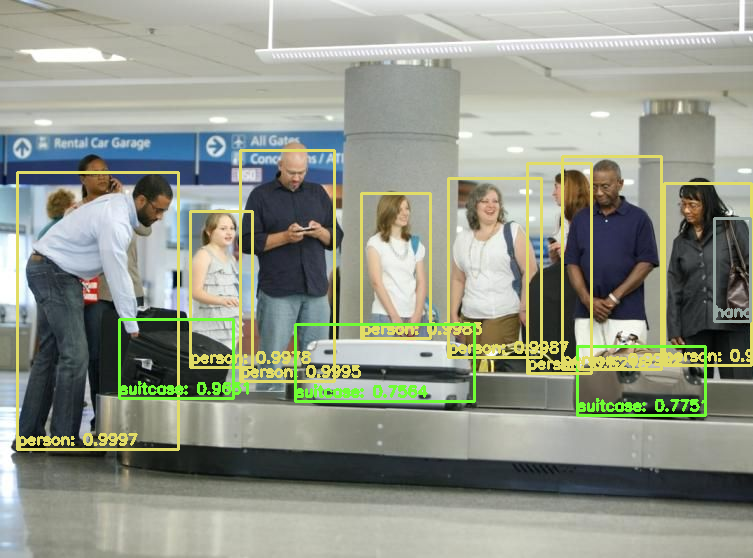

In [10]:
PATH_TO_IMAGE = 'yolo_data/yolo-object-detection/images/baggage_claim.jpg'
yolo = YOLO(PATH_TO_YOLO, CONFIDENCE, THRESHOLD)  
image = cv2.imread(PATH_TO_IMAGE)
image = yolo.detect(image)
cv2_imshow(image)

[INFO] YOLO took 2.121221 seconds


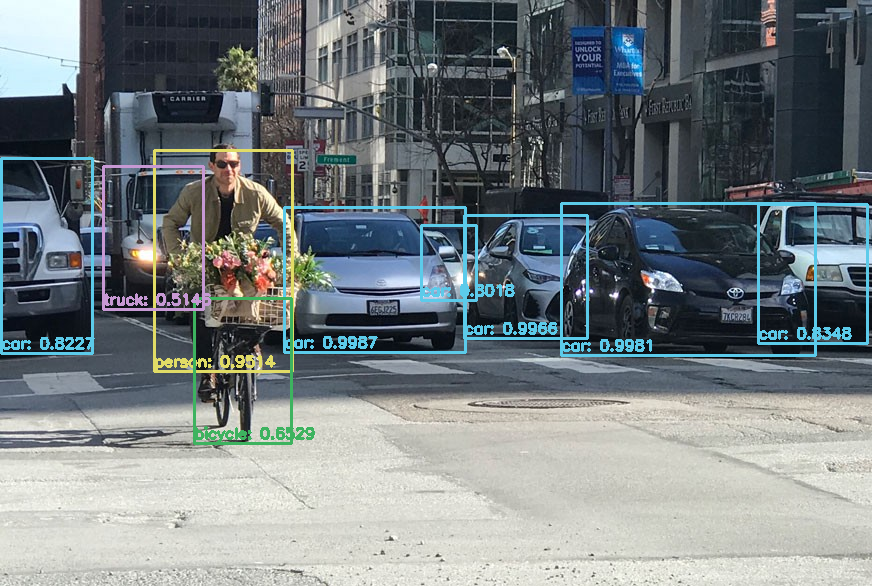

In [11]:
image = cv2.imread('traffic.jpeg')
image = yolo.detect(image)
cv2_imshow(image)